<a href="https://colab.research.google.com/github/PochkaChaiki/gasReserves/blob/main/GasReservesCalculations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import scipy.stats as st
from scipy.optimize import fsolve
from matplotlib import pyplot as plt
import seaborn as sns

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

Constants

In [ ]:
zero_c_to_k = 273
norm_temp_c = 20
pres_std_cond = 0.101325 * 1e6

## Initial data

In [ ]:
amount_of_vars = 3000

In [ ]:
df_init_data = pd.DataFrame(columns=['area', 'effective_thickness', 'porosity_coef', 'gas_saturation_coef', 'init_reservoir_pressure',
                                     'relative_density', 'reservoir_temp', 'permeability'],
                            index=['value', 'min', 'max'])

df_init_data['area']                       = {"value":38_556 * 1e3, "min":36_628.20 * 1e3 , "max":40_483.80 * 1e3}
df_init_data['effective_thickness']        = {"value":11.10,   "min":10.50,     "max":12.15}
df_init_data['porosity_coef']              = {"value":0.091,    "min":0.0067,      "max":0.1278}
df_init_data['gas_saturation_coef']        = {"value":0.7,     "min":0.65,      "max":0.75}
df_init_data['init_reservoir_pressure']    = {"value":32.30 * 1e6,   "min":29.07 * 1e6,     "max":35.53 * 1e6}
df_init_data['relative_density']           = {"value":0.6348,    "min":0.6267,      "max":0.6429}
df_init_data['reservoir_temp']             = {"value":320.49,  "min":288.44,    "max":352.54}
df_init_data['permeability']               = {"value":0.75,    "min":0.002,         "max":19.14}

In [ ]:
df_init_data

,area,effective_thickness,porosity_coef,gas_saturation_coef,init_reservoir_pressure,relative_density,reservoir_temp,permeability
value,38556000.0,11.10,0.0910,0.70,32300000.0,0.6348,320.49,0.750
min,36628200.0,10.50,0.0067,0.65,29070000.0,0.6267,288.44,0.002
max,40483800.0,12.15,0.1278,0.75,35530000.0,0.6429,352.54,19.140


## Results

In [ ]:
df_result_data = pd.DataFrame(columns=['area_volume', 'pore_volume', 'temp_correction', 'fin_reservoir_pressure',
                                       'critical_pressure', 'critical_temp', 'init_overcompress_coef',
                                       'fin_overcompress_coef', 'geo_gas_reserves', 'dry_gas_init_reserves'],
                              index=['value', 'min', 'max'])

df_result_data['area_volume']            = df_init_data['area'] * df_init_data['effective_thickness']
df_result_data['pore_volume']            = df_result_data['area_volume'] * df_init_data['porosity_coef']
df_result_data['temp_correction']        = (zero_c_to_k * 2 + norm_temp_c) / (zero_c_to_k + df_init_data['reservoir_temp'] )
df_result_data['fin_reservoir_pressure'] = np.exp(1293 * 1e-9 * 2700 * df_init_data['relative_density']) # What are this magical numbers?
df_result_data['critical_pressure']      = (4.892 - 0.4048 * df_init_data['relative_density']) * 1e6 # Same question
df_result_data['critical_temp']          = 94.717 + 170.8 * df_init_data['relative_density'] # Same question
df_result_data['init_overcompress_coef'] = (0.4 * np.log10(df_init_data['reservoir_temp'] / df_result_data['critical_temp']) + 0.73)**(df_init_data['init_reservoir_pressure'] / df_result_data['critical_pressure']) + 0.1 * df_init_data['init_reservoir_pressure'] / df_result_data['critical_pressure'] # Same question
df_result_data['fin_overcompress_coef']  = (0.4 * np.log10(df_init_data['reservoir_temp'] / df_result_data['critical_temp']) + 0.73)**(df_result_data['fin_reservoir_pressure'] / df_result_data['critical_pressure']) + 0.1 * df_result_data['fin_reservoir_pressure'] / df_result_data['critical_pressure'] # Same question
df_result_data['geo_gas_reserves']       = df_init_data['area'] * df_init_data['effective_thickness'] * df_init_data['porosity_coef'] * df_init_data['gas_saturation_coef'] * df_init_data['init_reservoir_pressure'] / df_result_data['init_overcompress_coef'] / pres_std_cond * df_result_data['temp_correction']

df_result_data['dry_gas_init_reserves']  = df_result_data['geo_gas_reserves'] * (100 - 0.012 - 0.003 - 0.012) / 100 # You're kidding me! Same question
df_result_data

,area_volume,pore_volume,temp_correction,fin_reservoir_pressure,critical_pressure,critical_temp,init_overcompress_coef,fin_overcompress_coef,geo_gas_reserves,dry_gas_init_reserves
value,427971600.0,3.894542e+07,0.953681,1.002219,4635032.96,203.14084,0.925583,1.0,8.954221e+09,8.951803e+09
min,384596100.0,2.576794e+06,1.008122,1.002190,4638311.84,201.75736,0.858788,1.0,5.640901e+08,5.639378e+08
max,491878170.0,6.286203e+07,0.904818,1.002247,4631754.08,204.52432,0.994840,1.0,1.503614e+10,1.503208e+10


In [ ]:
df_stat_params = pd.DataFrame(columns=['area', 'effective_thickness', 'porosity_coef', 'gas_saturation_coef', 'permeability'],
                            index=['distribution', 'params'])
df_stat_params['area'] = {'distribution': 'norm', 'params': {'mean': 38556 * 1e3, 'sigma': 3650 * 1e3}}
df_stat_params['effective_thickness'] = {'distribution': 'norm', 'params': {'mean': 11.10, 'sigma': 0.867}}
df_stat_params['porosity_coef'] = {'distribution': 'norm', 'params': {'mean': 0.09, 'sigma': 0.013}}
df_stat_params['gas_saturation_coef'] = {'distribution': 'norm', 'params': {'mean': 0.7, 'sigma': 0.01}}
df_stat_params['permeability'] = {'distribution': 'norm', 'params': {'mean': 9.569, 'sigma': 6.766}}

## Statistic

In [ ]:
df_stat_data = pd.DataFrame(columns=['area', 'effective_thickness', 'porosity_coef', 'gas_saturation_coef'])

for var in df_stat_data.columns:
    loc, scale = tuple(df_stat_params[var]['params'].values())
    # lb, rb = (df_init_data[var]['min'] - loc) / scale, (df_init_data[var]['max'] - loc) / scale
    # df_stat_data[var] = st.truncnorm.rvs(lb, rb, loc=loc, scale=scale, size=amount_of_vars)
    df_stat_data[var] = st.norm.rvs(loc=loc, scale=scale, size=amount_of_vars)

In [ ]:
# area                = st.truncnorm.rvs(*(df_init_data['area']['min'], df_init_data['area']['max'], *tuple(df_stat_params['area']['params'].values()), amount_of_vars))

In [ ]:
reserves = df_stat_data.prod(axis=1) * df_init_data['init_reservoir_pressure']['value'] * df_result_data['temp_correction']['value'] / df_result_data['init_overcompress_coef']['value'] / pres_std_cond

In [ ]:
fig = make_subplots(rows=1, cols=5)
for var, i in zip(df_stat_data.columns, range(1,6)):
    fig.add_trace(
        go.Histogram(x=df_stat_data[var], nbinsx=14), row=1, col=i)

fig.add_trace(go.Histogram(x=reserves, nbinsx=14), row=1, col=5)
fig

### Params sensitivity

In [ ]:
df_sens = pd.DataFrame(dict(min=df_stat_data.min(), mean=df_stat_data.mean(), max=df_stat_data.max()))
df_sens

,min,mean,max
area,2.475751e+07,3.853308e+07,5.297302e+07
effective_thickness,7.561001e+00,1.107942e+01,1.386452e+01
porosity_coef,4.213033e-02,9.043066e-02,1.413065e-01
gas_saturation_coef,6.642903e-01,6.998664e-01,7.334547e-01


In [ ]:
const_multiplier = df_init_data['init_reservoir_pressure']['value'] * df_result_data['temp_correction']['value'] / df_result_data['init_overcompress_coef']['value'] / pres_std_cond

In [ ]:
df_reserves_affection = pd.DataFrame(columns=['min', 'max'], index=df_sens.index)
for var in df_sens.index:
    df_reserves_affection['min'][var] = reserves.mean() - df_sens['min'][var] * df_sens.loc[df_sens.index != var]['mean'].prod() * const_multiplier
    df_reserves_affection['max'][var] = df_sens['max'][var] * df_sens.loc[df_sens.index != var]['mean'].prod() * const_multiplier - reserves.mean()
df_reserves_affection

,min,max
area,3171385066.501299,3327057213.044876
effective_thickness,2816960431.039103,2232221685.830095
porosity_coef,4738791603.905186,4994204619.067568
gas_saturation_coef,449796577.866896,427249454.114992


In [ ]:
df_affection = pd.DataFrame(dict(
    kmin=df_reserves_affection['min']/df_reserves_affection['min'].sum(),
    kmax=abs(df_reserves_affection['max'])/df_reserves_affection['max'].sum()
))
df_affection

,kmin,kmax
area,0.283744,0.30299
effective_thickness,0.252033,0.203285
porosity_coef,0.42398,0.454815
gas_saturation_coef,0.040243,0.038909


In [ ]:
fig2 = make_subplots(rows=1,cols=2)
fig2.add_trace(
    go.Bar(
        x=df_affection['kmin'],
        y=df_affection.index,
        orientation='h',
        name='Влияние в меньшую сторону',
        ),
    row=1,
    col=1
)
fig2.add_trace(
    go.Bar(
        x=df_affection['kmax'],
        y=df_affection.index,
        orientation='h',
        name='Влияние в большую сторону',
        ),
    row=1,
    col=2
)

fig2.update_layout(
    xaxis=dict(
        domain=[0.0, 0.5],
        autorange="reversed"
    ),
    xaxis2=dict(domain=[0.5, 1]),
    yaxis=dict(ticklabelstandoff=15),
    yaxis2=dict(visible=False),
    legend=dict(
        orientation='h',
        xanchor='center',
        x=0.5
    )
)


annotations=[]

# Adding labels
for ykmin, ykmax, xd in zip(df_affection['kmin'], df_affection['kmax'], df_affection.index):
    # labeling the bar net worth
    annotations.append(dict(xref='x1', yref='y1',
                            y=xd, x=ykmin+0.03,
                            text=str(np.round(ykmin*100, 1)) + '%',
                            showarrow=False))
    annotations.append(dict(xref='x2', yref='y2',
                            y=xd, x=ykmax+0.03,
                            text=str(np.round(ykmax*100, 1)) + '%',
                            showarrow=False))

fig2.update_layout(annotations=annotations)
fig2

### P10, P50, P90

In [ ]:
p10 = st.norm.ppf(0.9, loc=reserves.mean(), scale=reserves.std())
p50 = st.norm.ppf(0.5, loc=reserves.mean(), scale=reserves.std())
p90 = st.norm.ppf(0.1, loc=reserves.mean(), scale=reserves.std())
p90, p50, p10

(6697436366.507963, 8873398194.487843, 11049360022.467722)

In [ ]:
df_prob_estimates = pd.DataFrame(dict(
    p90=st.norm.ppf(0.1, loc=df_stat_data.mean(), scale=df_stat_data.std()),
    p50=st.norm.ppf(0.5, loc=df_stat_data.mean(), scale=df_stat_data.std()),
    p10=st.norm.ppf(0.9, loc=df_stat_data.mean(), scale=df_stat_data.std()),
), index=df_stat_data.columns)
df_prob_estimates.loc["reserves"] = [p90, p50, p10]
df_prob_estimates

,p90,p50,p10
area,3.386927e+07,3.853308e+07,4.319689e+07
effective_thickness,9.956724e+00,1.107942e+01,1.220212e+01
porosity_coef,7.351244e-02,9.043066e-02,1.073489e-01
gas_saturation_coef,6.867894e-01,6.998664e-01,7.129434e-01
reserves,6.697436e+09,8.873398e+09,1.104936e+10


In [ ]:
# fig3 = go.Figure()
fig3 = px.ecdf(reserves)
fig3.add_trace(go.Scatter(x=[p90, p50, p10], y=[0.1, 0.5, 0.9], mode='markers', marker_size=20))
fig3

## Development indicators

In [ ]:
permeability = abs(st.norm.rvs(loc=df_stat_params['permeability']['params']['mean'], scale=df_stat_params['permeability']['params']['sigma'], size=amount_of_vars))
permeability.mean(), permeability.std()

(9.852882451721403, 5.9067208142712735)

In [ ]:
permeability_p10 = st.norm.ppf(0.9, loc=permeability.mean(), scale=permeability.std())
permeability_p50 = st.norm.ppf(0.5, loc=permeability.mean(), scale=permeability.std())
permeability_p90 = st.norm.ppf(0.1, loc=permeability.mean(), scale=permeability.std())
permeability_p10, permeability_p50, permeability_p90

(17.42264975848563, 9.852882451721403, 2.2831151449571756)

### Parameters for evaluation

In [ ]:
init_pressure = df_init_data['init_reservoir_pressure']['value']
reservoir_temp = df_init_data['reservoir_temp']['value']
relative_density = df_init_data['relative_density']['value']
init_overcompress_coef = df_result_data['init_overcompress_coef']['value'] # 0.94
max_depression = 0.2 * 1e6
required_whole_gas_production = 12 * 1e7
reserve_ratio = 1.05
operations_ratio = 0.98
porosity_coef = df_init_data['porosity_coef']['value']
gas_saturation_coef = 0.72                             # alpha
avg_well_temp = (reservoir_temp + 293) / 2
pipe_diameter = 0.114
well_height = 2700
pipe_roughness = 0.0001
init_num_wells = 1
trail_length = 2300
trail_diameter = 0.168
trail_roughness = 0.0001
avg_trail_temp = 323.15
main_gas_pipeline_pressure = 4 * 1e6
input_cs_temp = 310
coef_K = 3326400
efficiency = 0.87
adiabatic_index = 1.3
density_athmospheric = relative_density * 28.96 / 22.4
viscosity = 0.012

lambda_trail = 0.067 * (2 * trail_roughness / trail_diameter)**0.2

In [ ]:
lambda_fontain = (2 * np.log10(7.41 * pipe_diameter/ 2 / pipe_roughness))**(-2)

Depends on dev indics mode:

In [ ]:
effective_thickness = df_prob_estimates['p50']['effective_thickness']
geo_gas_reserves = df_prob_estimates['p10']['reserves']
annual_production = geo_gas_reserves * 0.045
permeability_k = permeability_p50
macro_roughness_l = 0.425 * 1e-9 * permeability_k ** 1.45
filtr_resistance_A = viscosity *  init_overcompress_coef * 0.1013 * reservoir_temp / (np.pi * permeability_k * effective_thickness * 293.15) * np.log(500/0.1)
filtr_resistance_B = density_athmospheric * 0.1013 *  init_overcompress_coef * reservoir_temp / macro_roughness_l / (2 * np.pi**2 *  effective_thickness**2 * 293.15) * (1/0.1 - 1/500)

In [ ]:
filtr_resistance_A, filtr_resistance_B, macro_roughness_l

(3.054900461291298e-05, 29609.46490859546, 1.1723457605688163e-08)

Initial values of varying parameters

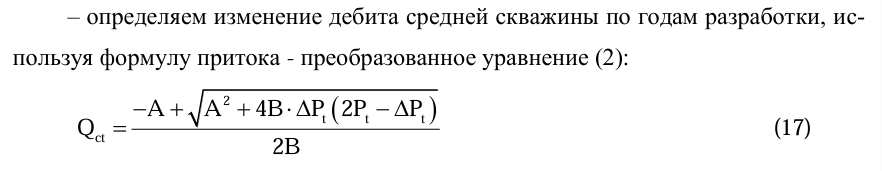

In [ ]:
year = 0
current_annual_production = 0
sum_current_annual_production = 0
current_pressure = init_pressure
overcompress_coef = init_overcompress_coef

In [ ]:
kig = 0
current_daily_production = 0
downhole_current_pressure = current_pressure - max_depression

s = 0
overcomp_coef_avg = 0
theta = 0

n_wells = 0

machines_num = 1
time_to_build = 6


In [ ]:
def func(x):
    return [init_pressure / init_overcompress_coef * (1 - x[2] / geo_gas_reserves) - x[0] / x[1],
            (0.4 * np.log10(reservoir_temp / df_result_data['critical_temp'].value) + 0.73)**(x[0] / df_result_data['critical_pressure'].value) + 0.1 * x[0] / df_result_data['critical_pressure'].value - x[1],
            sum_current_annual_production - x[2] + 365 * n_wells * operations_ratio * (-filtr_resistance_A + np.sqrt(filtr_resistance_A**2 + 4 * filtr_resistance_B * max_depression * (2*x[0] - max_depression))) / 2 / filtr_resistance_B]

In [ ]:
list_annual_production = []
list_current_pressure = []
list_overcompress_coef = []
list_daily_production = []
list_n_wells = []

In [ ]:
while (kig < 0.5):
    year += 1
    ## Evaluating not relying on formulas in block-scheme
    if 365 * current_daily_production * n_wells * operations_ratio <= annual_production:
        n_wells += np.trunc(12 / (machines_num * time_to_build))

    current_pressure, overcompress_coef, _ = tuple(fsolve(func, [current_pressure, overcompress_coef, sum_current_annual_production]))
    current_daily_production = (-filtr_resistance_A + np.sqrt(filtr_resistance_A**2 + 4 * filtr_resistance_B * max_depression * (2*current_pressure - max_depression))) / 2 / filtr_resistance_B

    if (current_pressure - max_depression > 0):
        downhole_current_pressure = current_pressure - max_depression
    else:
        downhole_current_pressure = 0;

    s = 0.03415 * relative_density * well_height / overcompress_coef / avg_well_temp
    # using Pt instead of Pcp --->
    overcomp_coef_avg = (0.4 * np.log10(avg_well_temp/df_result_data['critical_temp'].value) + 0.73)**(current_pressure/df_result_data['critical_pressure'].value) + 0.1 * current_pressure/df_result_data['critical_pressure'].value
    theta = 0.0132 * 10**(-10) * lambda_fontain * overcomp_coef_avg**2 * avg_well_temp**2 * (np.exp(2 * s) - 1) / pipe_diameter**5

    if downhole_current_pressure > 0:
        wellhead_pressure = np.sqrt((downhole_current_pressure**2 - theta * current_daily_production**2) / np.exp(2 * s))
    else:
        wellhead_pressure = 0


    if 365 * current_daily_production * n_wells * operations_ratio > annual_production:
        current_annual_production = annual_production
    else:
        current_annual_production = 365 * current_daily_production * n_wells * operations_ratio

    sum_current_annual_production += current_annual_production
    kig = sum_current_annual_production / geo_gas_reserves

    list_annual_production.append(current_annual_production)
    list_current_pressure.append(current_pressure)
    list_daily_production.append(current_daily_production)
    list_n_wells.append(n_wells)
    list_overcompress_coef.append(overcompress_coef)

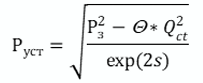

In [ ]:
firstLoopResults = pd.DataFrame(dict(annual_production = list_annual_production, daily_production = list_daily_production, current_pressure = list_current_pressure, overcompress_coef = list_overcompress_coef, n_wells = list_n_wells))

In [ ]:
firstLoopResults

,annual_production,daily_production,current_pressure,overcompress_coef,n_wells
0,1.490430e+07,20833.518975,3.222890e+07,0.924793,2.0
1,2.974306e+07,20787.714232,3.208778e+07,0.923232,4.0
2,4.446852e+07,20719.655072,3.187866e+07,0.920937,6.0
3,5.903499e+07,20630.063946,3.160444e+07,0.917959,8.0
4,7.339948e+07,20519.842593,3.126869e+07,0.914364,10.0
5,8.752218e+07,20390.033861,3.087560e+07,0.910227,12.0
6,1.013668e+08,20241.780921,3.042969e+07,0.905629,14.0
7,1.149006e+08,20076.286720,2.993578e+07,0.900656,16.0
8,1.280945e+08,19894.776022,2.939872e+07,0.895397,18.0
9,1.409228e+08,19698.461768,2.882336e+07,0.889936,20.0


In [ ]:
kig, year, current_pressure, n_wells

(0.5069137577169431, 30, 14264886.224210743, 60.0)

In [ ]:
current_pressure, overcompress_coef, sum_current_annual_production

(14264886.224210743, 0.8290074525941433, 5601072609.35648)

In [ ]:
fsolve(func, [current_pressure, overcompress_coef, sum_current_annual_production])

array([1.3538880e+07, 8.3091806e-01, 5.8902514e+09])

Not finished ---V!!!

In [ ]:
def func2(x):
    return [init_pressure / init_overcompress_coef * (1 - x[2] / geo_gas_reserves) - x[0] / x[1],
            (0.4 * np.log10(reservoir_temp / df_result_data['critical_temp'].value) + 0.73)**(x[0] / df_result_data['critical_pressure'].value) + 0.1 * x[0] / df_result_data['critical_pressure'].value - x[1],
            sum_current_annual_production - x[2] + 365 * n_wells * operations_ratio / 2 / 10**6 / reserve_ratio * ((-filtr_resistance_A + np.sqrt(filtr_resistance_A**2 + 4 * filtr_resistance_B * max_depression * (2*x[0] - max_depression))) / 2 / filtr_resistance_B + current_daily_production)]

In [ ]:
while True:
    year += 1
    current_pressure, overcompress_coef, _ = tuple(fsolve(func2, [current_pressure, overcompress_coef, sum_current_annual_production]))

    new_current_daily_production = (-filtr_resistance_A + np.sqrt(filtr_resistance_A**2 + 4 * filtr_resistance_B * max_depression * (2*current_pressure - max_depression))) / 2 / filtr_resistance_B

    if (current_pressure - max_depression > 0):
        downhole_current_pressure = current_pressure - max_depression
    else:
        downhole_current_pressure = 0;

    s = 0.03415 * relative_density * well_height / overcompress_coef / avg_well_temp
    # using Pt instead of Pcp --->
    overcomp_coef_avg = (0.4 * np.log10(avg_well_temp/df_result_data['critical_temp'].value) + 0.73)**(current_pressure/df_result_data['critical_pressure'].value) + 0.1 * current_pressure/df_result_data['critical_pressure'].value
    theta = 0.0132 * 10**(-10) * lambda_fontain * overcomp_coef_avg**2 * avg_well_temp**2 * (np.exp(2 * s) - 1) / pipe_diameter**5

    print("current_pressure: ", current_pressure)
    if downhole_current_pressure > 0:
        wellhead_pressure = np.sqrt((downhole_current_pressure**2 - theta * new_current_daily_production**2) / np.exp(2 * s))
    else:
        wellhead_pressure = 0

    current_annual_production = 365 * (current_daily_production + new_current_daily_production) * n_wells * operations_ratio

    sum_current_annual_production += current_annual_production
    kig = sum_current_annual_production / geo_gas_reserves
    print("kig: ", kig)
    ukpg_pressure = np.sqrt(wellhead_pressure**2 - lambda_trail * relative_density * overcomp_coef_avg * avg_well_temp * trail_length / (trail_diameter**5 * coef_K**2) * (current_daily_production * n_wells)**2)
    print(ukpg_pressure, wellhead_pressure, wellhead_pressure + max_depression)
    if wellhead_pressure + max_depression <= ukpg_pressure or current_pressure < 0.05 * init_pressure:

        break

current_pressure:  14264885.511292545
kig:  0.5606521064892508
11173084.490128284 11173084.622398943 11373084.622398943
current_pressure:  12779881.42590868
kig:  0.6129430274001133
10005944.994513057 10005945.143144332 10205945.143144332
current_pressure:  11350593.499373036
kig:  0.6637583411086356
8885529.467765998 8885529.636675172 9085529.636675172
current_pressure:  9966022.852578865
kig:  0.713051813034904
7800960.161053072 7800960.355741188 8000960.355741188
current_pressure:  8617209.98737664
kig:  0.7607561295119228
6743247.547206358 6743247.775721355 6943247.775721355
current_pressure:  7296909.752926661
kig:  0.8067775987120507
5704953.2235971 5704953.498353106 5904953.498353106
current_pressure:  5999491.014636898
kig:  0.8509870114443231
4680061.568054168 4680061.909609923 4880061.909609923
current_pressure:  4721106.197984452
kig:  0.8932030894733979
3664095.508013832 3664095.9540146003 3864095.9540146003
current_pressure:  3460283.869099953
kig:  0.9331591335183742
2654

In [ ]:
kig, year, current_pressure

(1.0040943088579002, 41, 1008194.5043073753)